In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [3]:
PATH = "../datasets/yeast_v4.1"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [5]:
ds_name = "yeast_v4.1"
test_dirs, train_dirs = dataset_source(data_path)
stats_tuple = Statistics.per_dataset(test_dirs, train_dirs, save_name=ds_name)

8
working on a dataset with length: 714


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs)
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_tuple)


 class to index mapping:
 {'Cit1_MC_WT': 0, 'Cit1_MC_mfb1KO': 1, 'Cit1_MC_mfb1KO_mmr1KO': 2, 'Cit1_MC_mmr1KO': 3}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


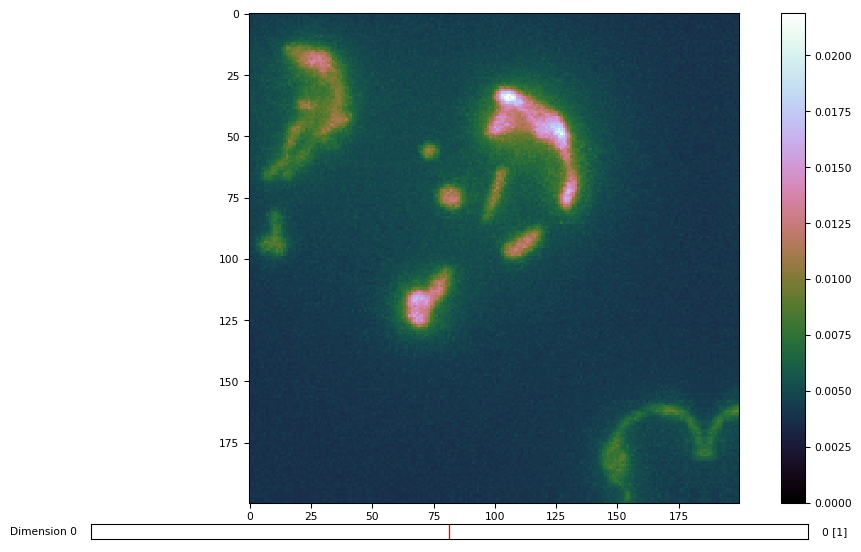

In [30]:
idx = 31
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [9]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [10]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [11]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [12]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], NUM_CLASSES), data)

In [13]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [14]:
wd=1e-5

In [20]:
learn.lr_find()

[0]: 100.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      43.623375  nan        0.285714  



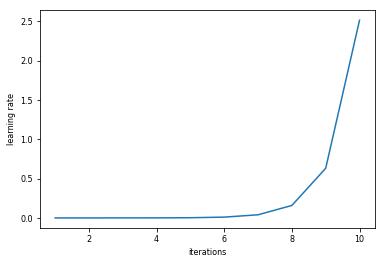

In [26]:
learn.sched.plot_lr()

In [15]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

[0]:  1.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      45.280859  37.900777  0.25      
[0]: 0.5143%                                            
[1]:  0.0%
[2]: 0.8286%
[3]:  0.0%
    1      29.962484  7.601977   0.314286  
[0]:  0.0%                                              
[1]: 0.8286%
[2]:  0.0%
[3]: 0.3429%
    2      19.564867  2.318319   0.285714  
[0]:  0.0%                                              
[1]: 0.8286%
[2]:  0.0%
[3]: 0.2286%
    3      14.018068  2.428342   0.292857  
[0]:  0.0%                                              
[1]:  0.0%
[2]:  0.0%
[3]: 0.8857%
    4      10.942685  2.554141   0.228571  
[0]: 0.4286%                                            
[1]: 0.05714%
[2]:  0.0%
[3]: 0.4286%
    5      8.638995   1.63317    0.235714  
[0]: 0.2286%                                            
[1]:  0.4%
[2]:  0.0%
[3]:  0.4%
    6      6.986002   1.373641   0.292857  


[array([1.09685]), 0.5357142857142857]

In [16]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_dataset_1')

[0]: 0.4286%                                             
[1]: 0.7714%
[2]: 0.05714%
[3]: 0.6286%
epoch      trn_loss   val_loss   accuracy   
    0      1.023597   1.084983   0.578571  
[0]: 0.6571%                                            
[1]: 0.7143%
[2]:  0.0%
[3]: 0.5143%
    1      1.018329   1.073588   0.571429  
[0]: 0.7143%                                            
[1]: 0.6571%
[2]:  0.0%
[3]: 0.5429%
    2      1.028076   1.072946   0.571429  
[0]: 0.6857%                                            
[1]: 0.7429%
[2]: 0.02857%
[3]: 0.4571%
    3      1.033983   1.045913   0.592857  
[0]: 0.7143%                                            
[1]: 0.7143%
[2]:  0.0%
[3]:  0.4%
    4      1.044867   1.080802   0.514286  
[0]: 0.6857%                                            
[1]: 0.7429%
[2]: 0.1714%
[3]: 0.3714%
    5      1.041002   1.0386     0.592857  
[0]: 0.5429%                                            
[1]: 0.7143%
[2]:  0.0%
[3]: 0.6571%
    6      1.036528   1.05

[array([0.86871]), 0.6285714302744184]

In [19]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_dataset_2')

[0]: 0.6286%                                             
[1]: 0.8286%
[2]:  0.2%
[3]: 0.7429%
epoch      trn_loss   val_loss   accuracy   
    0      0.662636   0.85563    0.678571  
[0]: 0.6571%                                             
[1]:  0.8%
[2]: 0.1714%
[3]: 0.7429%
    1      0.690771   0.867319   0.657143  
[0]: 0.6571%                                             
[1]: 0.7714%
[2]: 0.1714%
[3]: 0.7429%
    2      0.68543    0.873896   0.65      
[0]:  0.6%                                               
[1]: 0.8571%
[2]: 0.1714%
[3]: 0.7143%
    3      0.682243   0.866559   0.657143  
[0]:  0.6%                                               
[1]:  0.8%
[2]:  0.2%
[3]: 0.7143%
    4      0.672696   0.852866   0.671429  
[0]: 0.5714%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.7143%
    5      0.672348   0.846414   0.685714  
[0]: 0.6857%                                             
[1]: 0.7429%
[2]:  0.2%
[3]: 0.7143%
    6      0.668761   0.

[0]:  0.6%                                               
[1]: 0.7714%
[2]: 0.1714%
[3]: 0.7143%
    58     0.616783   0.859462   0.635714  
[0]:  0.6%                                               
[1]: 0.7714%
[2]: 0.1714%
[3]: 0.7143%
    59     0.614293   0.855604   0.65      
[0]:  0.6%                                               
[1]:  0.8%
[2]: 0.1714%
[3]: 0.6857%
    60     0.618072   0.858012   0.642857  
[0]: 0.5714%                                             
[1]: 0.7714%
[2]: 0.1714%
[3]: 0.7143%
    61     0.619174   0.855919   0.635714  
[0]: 0.6571%                                             
[1]:  0.8%
[2]:  0.2%
[3]: 0.6857%
    62     0.612286   0.86872    0.635714  
[0]:  0.6%                                               
[1]: 0.7714%
[2]: 0.1714%
[3]: 0.7143%
    63     0.613067   0.863359   0.635714  
[0]: 0.6286%                                             
[1]: 0.7714%
[2]: 0.1714%
[3]: 0.6857%
    64     0.606995   0.856065   0.642857  
[0]: 0.5714%       

   116     0.581855   0.872588   0.628571  
[0]:  0.6%                                               
[1]: 0.7429%
[2]: 0.1714%
[3]: 0.7143%
   117     0.578372   0.866344   0.65      
[0]: 0.5714%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.6857%
   118     0.581279   0.861084   0.635714  
[0]: 0.5714%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.6857%
   119     0.58039    0.86258    0.621429  
[0]: 0.6571%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.6857%
   120     0.579828   0.873845   0.621429  
[0]:  0.6%                                               
[1]: 0.7714%
[2]:  0.2%
[3]: 0.7143%
   121     0.574856   0.869903   0.635714  
[0]: 0.6571%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.6857%
   122     0.572576   0.882397   0.628571  
[0]: 0.6286%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.6857%
   123     0.573496   0.8

[array([0.87093]), 0.6428571428571429]

In [34]:
%time learn.fit(1e-3, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

[0]: 0.6857%                                             
[1]: 0.7714%
[2]:  0.2%
[3]: 0.7143%
epoch      trn_loss   val_loss   accuracy   
    0      0.632054   0.853882   0.692857  
CPU times: user 5.95 s, sys: 1.97 s, total: 7.92 s
Wall time: 5.92 s


[array([0.85388]), 0.6928571428571428]

In [20]:
learn.load('Objective_A_Resnet_per_dataset_2')

[[28  6  9  4]                               
 [ 6 26  4  2]
 [ 0  1 12  2]
 [ 1  2 10 27]]


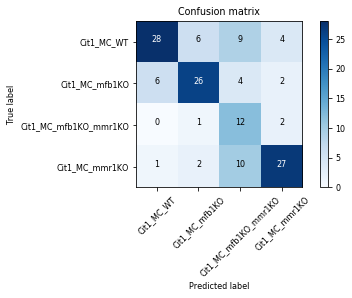

In [35]:
# analyze results
log_preds, y = learn.TTA()
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

In [30]:
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[0], axis=1)

[[21  4  5  4]                               
 [ 3 19  7  5]
 [ 2  0  4  2]
 [ 4  3  9 13]]


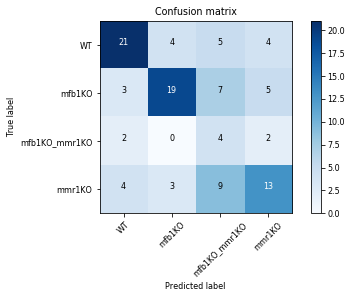

In [32]:
from sklearn.metrics import confusion_matrix
from resources.plots import *
import pickle
log_preds, y = learn.TTA()
preds = np.argmax(log_preds[1], axis=1)
cm = confusion_matrix(preds,y)
with open('confusion_matrix.32epochs.per_dataset.array','wb') as file:
    pickle.dump(cm,file)
plot_confusion_matrix(cm, data.classes)

In [ ]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

In [ ]:
learn.save('tmp_resnet_clr')